# Прогнозирование вероятности оттока пользователей для фитнес-центра

1. [Введение](#start)
2. [Загрузка и исследовательский анализ данных](#eda)
3. [Построение модели прогнозирования оттока клиентов](#models)
4. [Кластеризация клиентов](#clusters)
5. [Общие выводы и рекомендации](#concl)

# Введение <a id="start"></a>

В текущей работе мы проведем анализ данных о пользователях фитнес-центра для прогнозирования вероятности оттока по каждому клиенту.  
Для начала загрузим данные и ознакомимся с ними, проверим на наличие пропусков. Изучим признаки, сравним средние значения признаков для тех, кто ушел в отток и тех, кто остался. Посторим графики распределения признаков. А так же построим матрицу корреляции признаков.  
Далее построим модель бинарной класиификации клиентов, целевой признак - факт оттока клиента в следующем месяце. Для этого сначала разобьем данные на обучающую и валидационную выборки. Обучим модель двумя способами  - логистической регрессией и случайным лесом. Оценим метрики регрессии по двум моделям, посмотрим какая из них показала лучшие результаты.  
После этого проведем кластеризацию клиентов. Сначала стандартизируем признаки, отложив столбец с данными по оттоку клиентов. Построим дендрограмму и посмотрим на сколько классов можно разбить клиентов. Потом обучим модель кластеризации и спрогнозируем кластеры клиентов. Посмотрим на средние данные по каждому кластеру и построим графики распределения. Расчитаем долю оттока для каждого кластера.  
На основе полученной информации предоставим рекомендации по удержанию клиентов.  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings 
warnings.filterwarnings("ignore")

# Загрузка и исследовательский анализ данных <a id="eda"></a>

Загрузим данные и изучим их.

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В имеющемся датафрейме 4000 записей, 14 столбцов. Пропусков в данных нет.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Средняя длительность абонементов около 5 месяцев, средний возвраст клиентов - 29 лет, среднее время с момента первого визита в фитнес-центр 3,7 месяцев, средняя суммарная выручка от других услуг - 147.
Процент клиентов, которые ушли в отток - 26,5%. Процент клиентов, которые являются сотрудниками компаний-партнеров, - 48,7%, 31% клиентов пришли по акции "приведи друга".

Посмотрим на средние значения признаков для тех, кто ушел и кто остался.

In [5]:
data.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Среди тех, кто ушел и кто остался, практически одинаковый процент проживает около фитнес-центра. Сотрудниками компании-партнера являются больше 50% клиентов из тех, кто не ушел. Среди тех, кто ушел, таких клиентов меньше - около 36%. Клиентов, пришедших по акции "приведи друга", почти в два раза больше среди, тех кто остался - около 35%. Клиенты, которые остаются, в среднем на три года старше клиентов, которые уходят. Тратят они на 43ед. больше, чем клиенты, которые уходят. Клиенты, которые ущли, в среднем посещяли занятия в два раза реже, чем клиенты, которые остались.

Посмотрим на распределение признаков на графиках. 

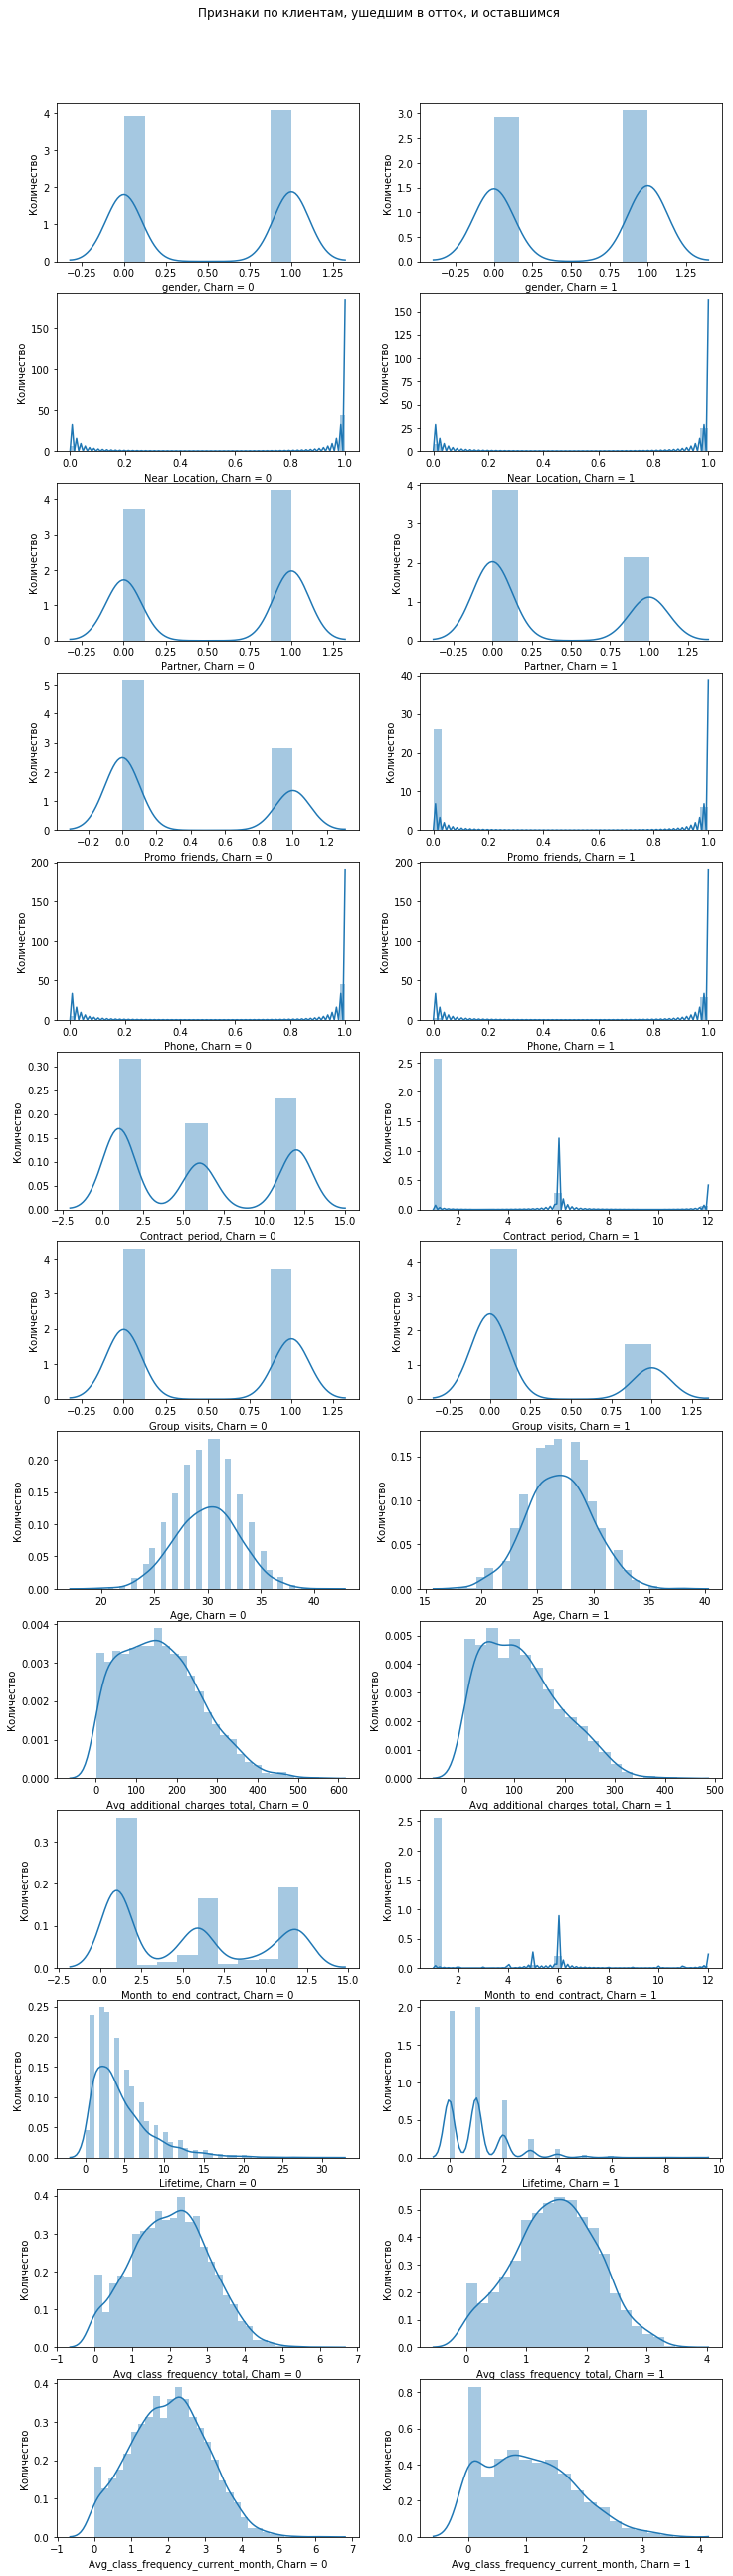

In [6]:
fig, axes = plt.subplots(13, 2)
fig.set_size_inches(12,45)
axes = axes.ravel()
i = 0
fig.suptitle('Признаки по клиентам, ушедшим в отток, и оставшимся', y=0.91)
for y in data.drop('Churn', axis=1).columns:
    for x  in data['Churn'].unique():
        sns.distplot(data[data['Churn']==x][y], ax = axes[i]).set(
            xlabel = '{}, Charn = {}'.format(y,x), ylabel='Количество')
        i += 1
plt.show()

На графиках видно, что клиенты, которые не уходят достаточно часто пользуются абонементами на 12 месяцев, тратят больше денег на дополнительные услуги, чаще посещают занятия. Среди клиентов, которые ушли, максимальное количество абонементов с одним месяцем, они меньше тратят денег и посещают заниятия 1-2 раза в неделю.

Посмотрим на матрицу корреляции.

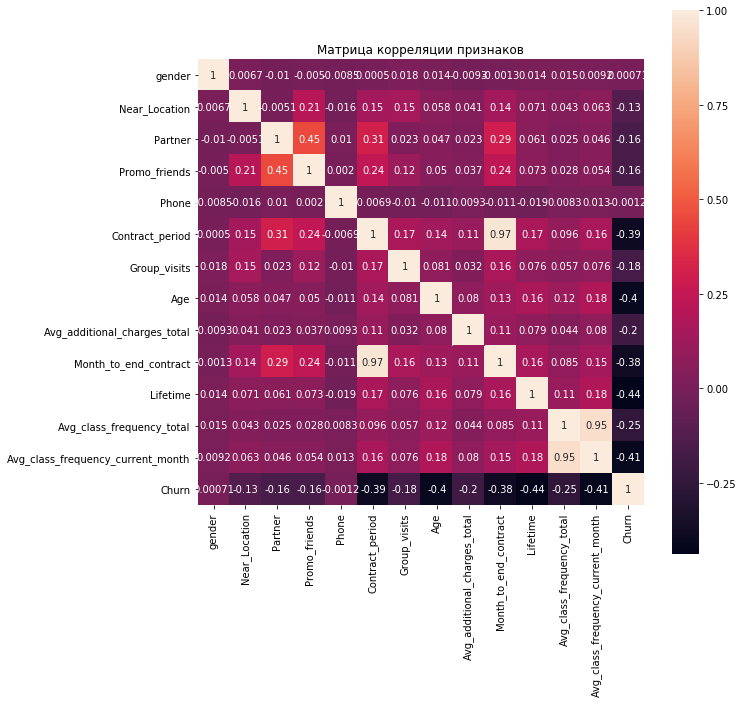

In [7]:
corr_m = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_m, annot = True, square = True)
plt.title('Матрица корреляции признаков')
plt.show()

В целом признаков, которые бы очень сильно коррелировали между собой, нет. Есть очевидная коррелиция между длительностью абонемента и сроком до окончания его действия, и есть зависимость между средним количеством посещений в прошлый месяц и за весь период.  
Удалим столбец с количеством месяцев до окончания абонемента.

In [8]:
data = data.drop(columns = 'Month_to_end_contract')

# Построение модели прогнозирования оттока клиентов <a id="models"></a>

Разделим данные на признаки и целевую переменную. Потом разделим их на обучающую и валидационную выборки.

In [9]:
X = data.drop('Churn', axis = 1)
y = data['Churn']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Обучим модель на train-выборке двумя способами - логистической регрессией и случайным лесом. Для этого создадим функцию, которая будет принимать на вход модели, а вовзвращать метрики accuracy, precision и recall, расчитанные на валидационной выборке. Определим, какая модель показала себя лучше.

In [11]:
models = [LogisticRegression(random_state = 0), RandomForestClassifier(random_state = 0)] 

In [12]:
def metrics(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    print(
        'acc:{:.2f} precision:{:.2f} recall:{:.2f} f1:{:.2f} roc_auc:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            roc_auc_score(y_test, y_prob)))


Применим созданную функцию к имеющимся данным.

In [13]:
for y in models:
    print(y)
    print()
    metrics(y, X_train, y_train, X_test, y_test)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

acc:0.93 precision:0.86 recall:0.83 f1:0.85 roc_auc:0.97

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

acc:0.90 precision:0.83 recall:0.75 f1:0.79 roc_auc:0.96



Логистическая регрессия прогнозирует 92% правильных ответов, остальные метрики у нее тоже выше, чем у случайного леса.

#  Кластеризация клиентов <a id="clusters"></a>

Проведем кластеризацию клиентов.  
Для начала стандартизируем данные без столбца 'Churn'. 

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Отобразим дендрограмму на основе стандартизированных признаков.

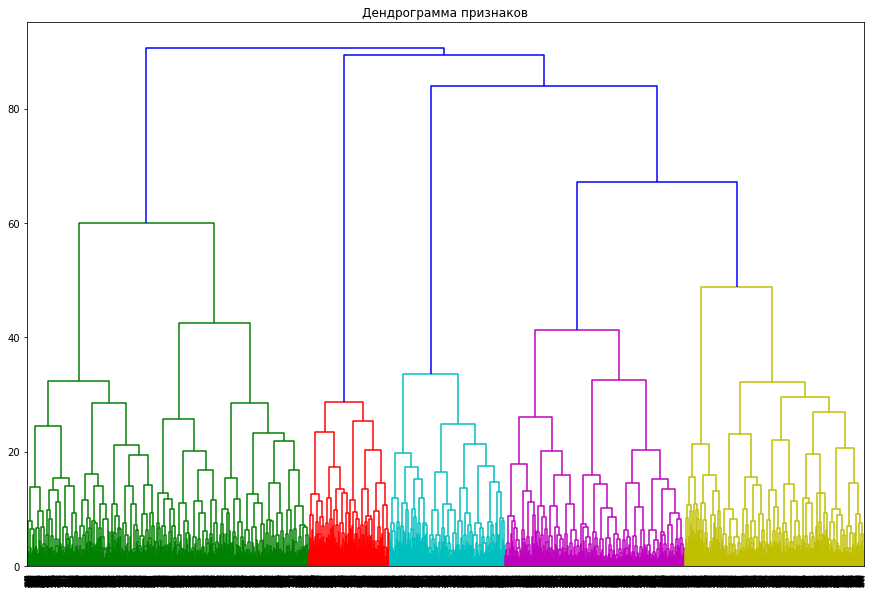

In [15]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков')
plt.show()

На графике пять цветов, предложено оптимальное число кластеров - 5.

Обучим модель кластеризации, за число кластеров возьмем  - 5. 

In [16]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)

Добавим столбец с кластерами к данным изначальной таблицы и посмотрим средние значения признаков для каждого кластера.

In [17]:
data['clusters'] = labels

In [18]:
data.groupby('clusters').mean().T

clusters,0,1,2,3,4
gender,0.478392,0.524675,0.494515,0.568736,0.495310
Near_Location,0.993970,0.862338,1.000000,0.970067,0.000000
Partner,0.947739,0.472727,0.240506,0.307095,0.487805
Promo_friends,0.879397,0.306494,0.095359,0.097561,0.075047
Phone,1.000000,0.000000,1.000000,0.998891,1.000000
Contract_period,7.831156,4.758442,2.483544,5.137472,2.859287
Group_visits,0.536683,0.425974,0.331646,0.483370,0.228893
Age,29.629146,29.283117,28.216034,30.288248,28.566604
Avg_additional_charges_total,154.788356,144.240418,131.341969,166.180576,136.384285
Lifetime,4.447236,3.922078,2.440506,5.011086,2.911820


Наименьший процент оттока у нулевого и последнего кластеров. У кластера под номером 0 наибольший процент клиентов, которые являются сотрудниками компаний-партнеров, так же наибольший процент клиентов, пришедших по акции "приведи друга", средний срок абонемента почти 11 месяцев, средние дополнительные траты около 161ед.
У кластера номер 4 количество клиентов, пришедших по акции "приведи друга" или являющихся сотрудниками компании-партнера гораздо меньше, они так же проживают или работают рядом с финтес-центром, как и первый кластер, у них гораздо ниже средний срок абонемента - 2,7 месяцев, дополнительные траты почти такие же как у первого кластера, они чаще посещаю фитнес-центр (почти три раза в неделю).  
Самый большой процент оттока у клиентов из второго и третьего кластеров. Клиенты из кластеры номер 3  живут рядом с фитнес-центром, среди них всего 35% являются сотрудниками компаний-партнеров, по акции "приведи друга" пришло 24%, срок их абонементов состовляет около 2 месяцев, они тратят меньше денег на дополнительные услуги, посещают занятия в среднем 1 раз в неделю. Клиенты кластера номер 2 не живут рядом с фитнес-центром, среди них наименьшее количество перешло по акции "приведи друга", они меньше тратят денег на доп. услуги, реже посещают занятия. 

Построим распределение признаков по каждому кластеру.

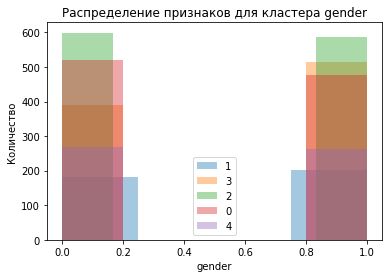

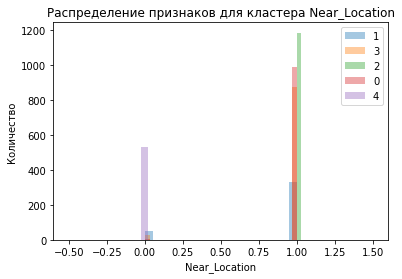

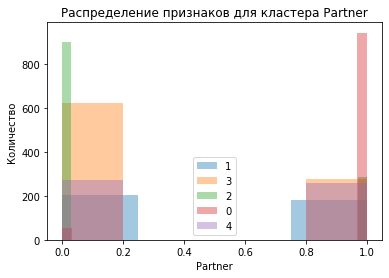

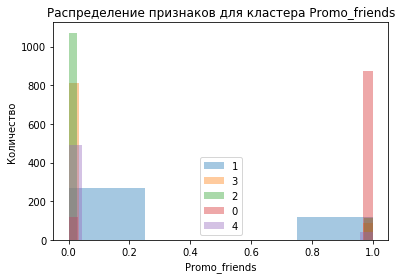

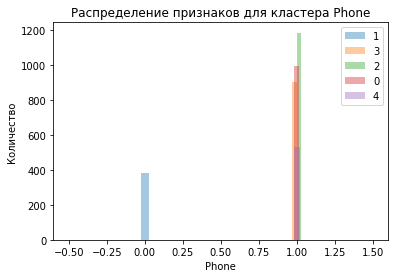

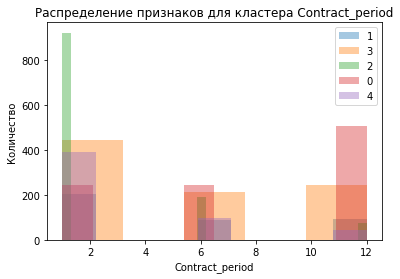

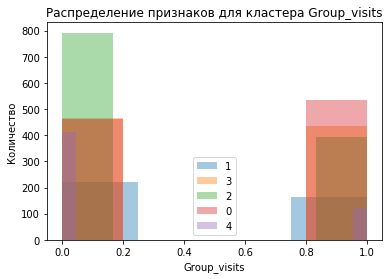

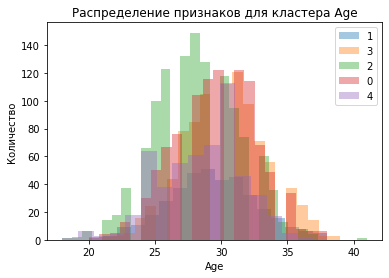

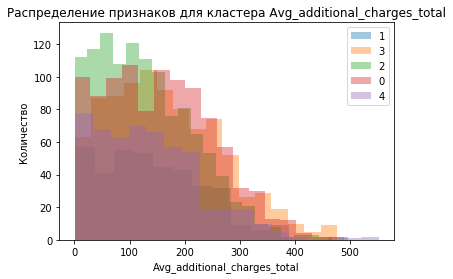

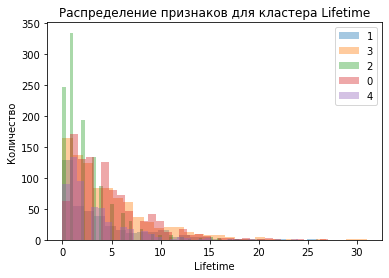

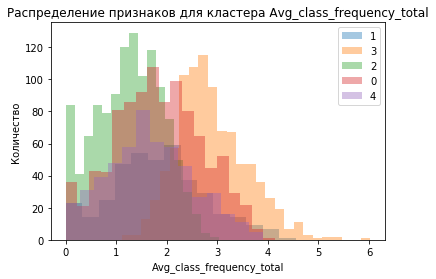

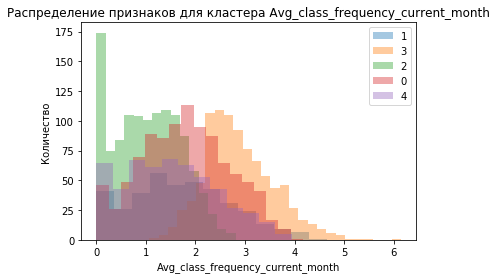

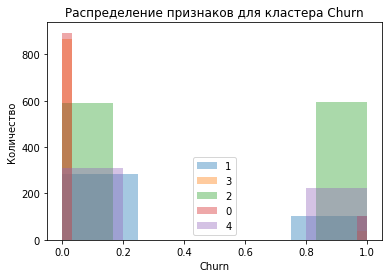

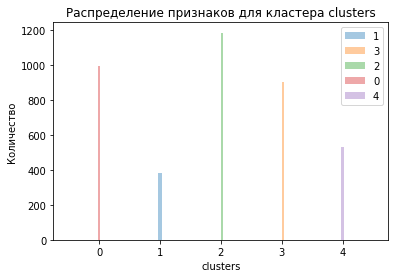

In [19]:
for x in data.columns:
    for cluster in data['clusters'].unique():
        sns.distplot(data[data['clusters']==cluster][x], label = cluster, kde=False)
        plt.legend()
        plt.title('Распределение признаков для кластера {}'.format(x))
        plt.ylabel('Количество')
    plt.show()

На графиках видно, что такие показатели, как пол, возраст, дополнительные траты, время с первого посещения фитнес-центра не сильно повлиялоя на формирование кластеров, на графике они по большей части перекрывают друг друга.
А вот проживание или работа рядом с центром, является ли клиент сотрудником компании-партнера или пришел по акции "приведи друга", длительность контракта и среднее количество посещений в неделю стали определяющими показателями для некоторых кластеров.

Отобразим общее количество клиентов по калстерам и процент оттока в каждом кластере.

In [20]:
churn_table = data.groupby('clusters').agg({'Churn': ['count', 'sum']})
churn_table.columns = ['total', 'churn']
churn_table['ratio'] = round(((churn_table['churn']/churn_table['total']) * 100), 1)
churn_table.sort_values(by='ratio', ascending=False)

,total,churn,ratio
clusters,,,
2,1185,595,50.2
4,533,224,42.0
1,385,103,26.8
0,995,102,10.3
3,902,37,4.1


Больше всего клиентов попало в нулевой и третий кластеры, и у этих же кластеров кардинальное различие в проценте оттока.  В нулеовом кластере процент ушедших клиентов составил всего около 3%, в третьем - 51%.

# Общие выводы и рекомендации <a id="concl"></a>

Мы изучили данные клиентов фитнес-центра. Провели исследовательский анализ данных, посмотрели на средние значения признаков и их распределение для клиентов, которые ушли и которые остались.  
Средняя длительность абонементов составляет около 5 месяцев, средний возвраст клиента - 29 лет, средняя выручка с клинта от доп. услуг - 147ед. Общий процент клиентов, которые ушли составил 26,5%.  
Далее мы обучили модели, прогнозирующие отток клиентов и по метрикам определили лучшую. Ей оказалась модель логистической регрессии - она прогнозирует правильные ответы в 93 случаях из ста.  
Потом мы провели кластеризацию клиентов, сравнили средние признаки для каждого кластера, посмотрели какие кластеры склонны к оттоку, а какие нет.  
В результате изучения кластеров можно сделать следующие выводы:
- клиенты, которые остаются, являются владельцами абоементов с большим сроком (в среднем 10 месяцев)
- среди клиентов, которые остаются, большое количество тех, кто является сотруднами компаний-партнеров или воспользовались акцией "приведи друга"
- клиенты, которые остаются, чаще посещают занятия и тратят больше денег на дополнительные услуги.

В качестве рекомендаций для взаимодействия и удержания клиентов можно предложить следующее:
 - развить систему скидок на абонементы с длительным сроком (6-12 месяцев) и на продление текущих абонементов
 - провести более активную кампанию по продвижению акции "приведи друга"
 - развивать сотрудничество с новыми компаниями-партнерами для привлечения их сотрудников, возможно пересмотреть систему скидок для текущих партнеров, чтобы привлечь больше сотрудников.